In [ ]:
pip install pandas matplotlib seaborn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load datasets
# Ensure 'historical_data.csv' and 'fear_greed_index.csv' are in the same folder
hist_df = pd.read_csv('historical_data.csv')
sent_df = pd.read_csv('fear_greed_index.csv')

# Initial Inspection
print(hist_df.info())
print(sent_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659 entries, 0 to 4658
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Account           4659 non-null   object 
 1   Coin              4659 non-null   object 
 2   Execution Price   4659 non-null   float64
 3   Size Tokens       4659 non-null   float64
 4   Size USD          4659 non-null   float64
 5   Side              4659 non-null   object 
 6   Timestamp IST     4659 non-null   object 
 7   Start Position    4659 non-null   float64
 8   Direction         4659 non-null   object 
 9   Closed PnL        4659 non-null   float64
 10  Transaction Hash  4659 non-null   object 
 11  Order ID          4659 non-null   int64  
 12  Crossed           4659 non-null   bool   
 13  Fee               4658 non-null   float64
 14  Trade ID          4658 non-null   float64
 15  Timestamp         4658 non-null   float64
dtypes: bool(1), float64(8), int64(1), object(6

In [ ]:
# 1. Standardize Dates
# Convert Hyperliquid IST time to date objects
hist_df['Timestamp IST'] = pd.to_datetime(hist_df['Timestamp IST'], dayfirst=True)
hist_df['Date'] = hist_df['Timestamp IST'].dt.date

# Convert Fear/Greed date to match
sent_df['date'] = pd.to_datetime(sent_df['date']).dt.date

# 2. Merge on Date
df = pd.merge(hist_df, sent_df, left_on='Date', right_on='date', how='inner')

# Drop redundant columns to keep it clean
df.drop(columns=['date', 'timestamp_y'], errors='ignore', inplace=True)
print(f"Merged Dataset: {df.shape[0]} rows")

Merged Dataset: 4653 rows


In [ ]:
# A trade is a win if Closed PnL > 0
df['is_win'] = df['Closed PnL'] > 0

# PnL Efficiency: How much profit was made relative to the size of the position
df['pnl_efficiency'] = df['Closed PnL'] / df['Size USD'].replace(0, 1)

# Group accounts to find 'Top Traders'
trader_rank = df.groupby('Account')['Closed PnL'].sum().sort_values(ascending=False)
top_threshold = trader_rank.quantile(0.95)
df['is_top_trader'] = df['Account'].isin(trader_rank[trader_rank >= top_threshold].index)

/tmp/ipython-input-1688194501.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=win_rate.index, y=win_rate.values, palette='coolwarm')


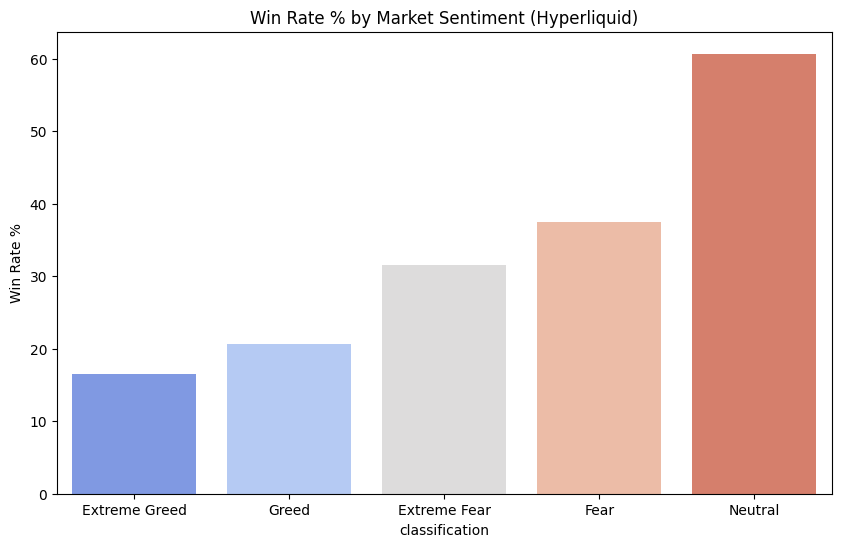

/tmp/ipython-input-1688194501.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='classification', y='pnl_efficiency', showfliers=False, palette='magma')


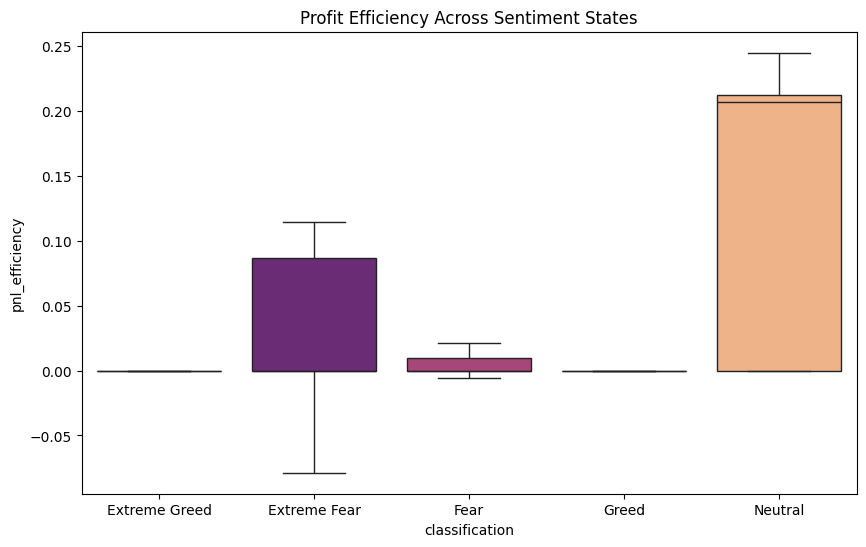

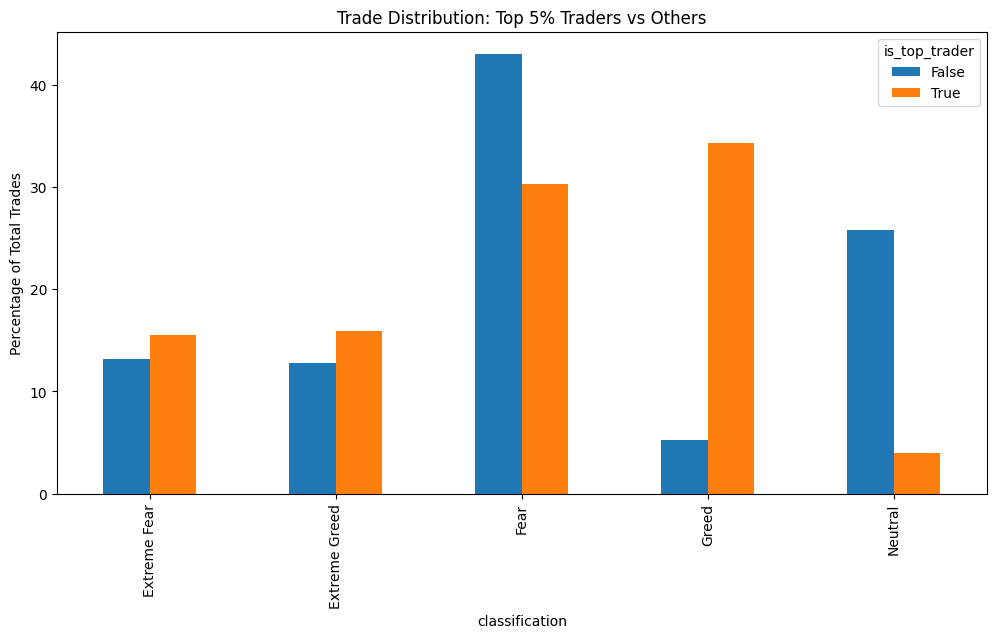

In [ ]:
# Win Rate by Sentiment
plt.figure(figsize=(10,6))
win_rate = df.groupby('classification')['is_win'].mean().sort_values() * 100
sns.barplot(x=win_rate.index, y=win_rate.values, palette='coolwarm')
plt.title('Win Rate % by Market Sentiment (Hyperliquid)')
plt.ylabel('Win Rate %')
plt.show()

# PnL Efficiency vs Sentiment
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='classification', y='pnl_efficiency', showfliers=False, palette='magma')
plt.title('Profit Efficiency Across Sentiment States')
plt.show()

# Top Trader Behavior
behavior = pd.crosstab(df['classification'], df['is_top_trader'], normalize='columns') * 100
behavior.plot(kind='bar', figsize=(12,6))
plt.title('Trade Distribution: Top 5% Traders vs Others')
plt.ylabel('Percentage of Total Trades')
plt.show()